<a href="https://colab.research.google.com/github/vphcap-res/DOA_deep_learning/blob/main/DOA_NN_20250211-1314.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install requirements**

In [1]:
#import os
#print(os.listdir())  # List all files in the current directory

In [2]:
# Install the dependencies from requirements.txt
#!pip install -r /content/requirements.txt

# Verify that packages are installed
#!pip freeze

# **Data prep**

In [28]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os

In [29]:
# Set random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure full determinism in TensorFlow operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)

print("✅ Random seed set. Training will be reproducible.")

✅ Random seed set. Training will be reproducible.


In [30]:
# Ensure deterministic TensorFlow behavior
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [31]:
# Uploaded file
df = pd.read_excel('DOA-data_65-66_for_NN.xlsx')

In [32]:
# Select relevant columns
columns_to_select = ['head', 'age', 'bw', 'lairagetemp', 'season', 'timetransport', 'durationtransport', 'lairagetime', 'classdoa']
df2 = df[columns_to_select]

In [33]:
# Encode the target variable (classdoa)
label_encoder = LabelEncoder()
df2.loc[:, 'classdoa'] = label_encoder.fit_transform(df2['classdoa'])
target = to_categorical(df2['classdoa'])  # One-hot encode the target variable

# **Train-test split**
**10-fold CV**

In [34]:
# Perform stratified splitting before preprocessing
predictors = df2.drop('classdoa', axis=1)

In [36]:
# ✅ Debugging and Fixing Final Model Training Process

import pandas as pd

# Check for missing categorical encoding on the final train and test sets
categorical_cols = ['season', 'timetransport']

# Ensure categorical columns exist before encoding
existing_categorical_cols = [col for col in categorical_cols if col in X_train.columns]

# Apply one-hot encoding to training and test sets
if existing_categorical_cols:
    X_train = pd.get_dummies(X_train, columns=existing_categorical_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=existing_categorical_cols, drop_first=True)

    # Ensure feature consistency between training and test sets
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Check if all columns are numeric (should not contain strings)
print("\n✅ Checking Data Types of X_train (Final Training Set):\n", X_train.dtypes)
print("\n✅ Checking Data Types of X_test (Final Test Set):\n", X_test.dtypes)

# Check if any NaN values exist after processing
print("\n⚠️ Checking for Missing Values in X_train:\n", X_train.isnull().sum())
print("\n⚠️ Checking for Missing Values in X_test:\n", X_test.isnull().sum())

# Check shapes to ensure X_train and X_test match before training
print("\n✅ Shape of X_train:", X_train.shape)
print("✅ Shape of X_test:", X_test.shape)

# Check if target labels are properly formatted
print("\n✅ Checking y_train Shape:", y_train.shape)
print("✅ Checking y_test Shape:", y_test.shape)


✅ Checking Data Types of X_train (Final Training Set):
 head                       int64
age                        int64
bw                       float64
lairagetemp              float64
durationtransport          int64
lairagetime                int64
season_Summer               bool
season_Winter               bool
timetransport_Morning       bool
timetransport_Night         bool
dtype: object

✅ Checking Data Types of X_test (Final Test Set):
 head                       int64
age                        int64
bw                       float64
lairagetemp              float64
durationtransport          int64
lairagetime                int64
season_Summer               bool
season_Winter               bool
timetransport_Morning       bool
timetransport_Night         bool
dtype: object

⚠️ Checking for Missing Values in X_train:
 head                     0
age                      0
bw                       0
lairagetemp              0
durationtransport        0
lairagetime            

## **Experiments: Selection of baseline model**

In [35]:
# ✅ Step 1: Split Data into Train (80%) and Test (20%) BEFORE CV
X_train, X_test, y_train, y_test = train_test_split(
    predictors, target, test_size=0.2, random_state=SEED, stratify=target
)

# ✅ Step 2: Define Model Architectures for Comparison
model_configs = [
    {"name": "Model 1", "layers": [100]},              # 1 hidden layer, 100 neurons
    {"name": "Model 2", "layers": [100, 100]},         # 2 hidden layers, 100 neurons each
    {"name": "Model 3", "layers": [200]},              # 1 hidden layer, 200 neurons
    {"name": "Model 4", "layers": [200, 200]}          # 2 hidden layers, 200 neurons each
]

# ✅ Step 3: Perform 10-Fold Cross-Validation on Training Set
k = 10
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

# Store cross-validation results
cv_results = {}

# Iterate through different model architectures
for model_config in model_configs:
    print(f"\n🔹 Running Cross-Validation for {model_config['name']}...")

    # Store performance across folds
    accuracy_scores = []
    loss_scores = []

    # Define EarlyStopping
    early_stopping_monitor = EarlyStopping(patience=3, restore_best_weights=True)

    # Cross-validation loop
    for fold, (train_index, val_index) in enumerate(kf.split(X_train, np.argmax(y_train, axis=1))):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Convert categorical features (if they exist)
        categorical_cols = ['season', 'timetransport']
        existing_categorical_cols = [col for col in categorical_cols if col in X_train_fold.columns]
        if existing_categorical_cols:
            X_train_fold = pd.get_dummies(X_train_fold, columns=existing_categorical_cols, drop_first=True)
            X_val_fold = pd.get_dummies(X_val_fold, columns=existing_categorical_cols, drop_first=True)
            X_val_fold = X_val_fold.reindex(columns=X_train_fold.columns, fill_value=0)

        # Define model architecture dynamically
        model = Sequential()
        model.add(Input(shape=(X_train_fold.shape[1],)))  # Input layer
        for neurons in model_config["layers"]:  # Add hidden layers
            model.add(Dense(neurons, activation='relu'))
        model.add(Dense(2, activation='softmax'))  # Output layer

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train_fold, y_train_fold, epochs=30, verbose=0, callbacks=[early_stopping_monitor], validation_data=(X_val_fold, y_val_fold))

        # Evaluate the model
        loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        accuracy_scores.append(accuracy)
        loss_scores.append(loss)

        # Print performance per fold
        print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}, Loss = {loss:.4f}")

    # Store cross-validation results
    cv_results[model_config["name"]] = {
        "mean_accuracy": np.mean(accuracy_scores),
        "std_accuracy": np.std(accuracy_scores),
        "mean_loss": np.mean(loss_scores),
        "std_loss": np.std(loss_scores)
    }


🔹 Running Cross-Validation for Model 1...
Fold 1: Accuracy = 0.7948, Loss = 0.4656
Fold 2: Accuracy = 0.8116, Loss = 0.4413
Fold 3: Accuracy = 0.7979, Loss = 0.4891
Fold 4: Accuracy = 0.7614, Loss = 0.5105
Fold 5: Accuracy = 0.7812, Loss = 0.5330
Fold 6: Accuracy = 0.7812, Loss = 0.6337
Fold 7: Accuracy = 0.7382, Loss = 0.5797
Fold 8: Accuracy = 0.7808, Loss = 0.4946
Fold 9: Accuracy = 0.7945, Loss = 0.5677
Fold 10: Accuracy = 0.7854, Loss = 0.6861

🔹 Running Cross-Validation for Model 2...
Fold 1: Accuracy = 0.7948, Loss = 0.4782
Fold 2: Accuracy = 0.8131, Loss = 0.5264
Fold 3: Accuracy = 0.7827, Loss = 0.5191
Fold 4: Accuracy = 0.7720, Loss = 0.6588
Fold 5: Accuracy = 0.7492, Loss = 0.5242
Fold 6: Accuracy = 0.7827, Loss = 0.6657
Fold 7: Accuracy = 0.7732, Loss = 0.6511
Fold 8: Accuracy = 0.8067, Loss = 0.4953
Fold 9: Accuracy = 0.7976, Loss = 0.4931
Fold 10: Accuracy = 0.7884, Loss = 0.7000

🔹 Running Cross-Validation for Model 3...
Fold 1: Accuracy = 0.7964, Loss = 0.4909
Fold 2: 

In [37]:
# ✅ Step 4: Select Best Model and Train on Full Training Set
best_model_config = max(cv_results, key=lambda x: cv_results[x]["mean_accuracy"])
print(f"\n🎯 Best Model Selected: {best_model_config}")

# Retrieve best model architecture
best_layers = next(m["layers"] for m in model_configs if m["name"] == best_model_config)

# Define final model with best architecture
final_model = Sequential()
final_model.add(Input(shape=(X_train.shape[1],)))
for neurons in best_layers:
    final_model.add(Dense(neurons, activation='relu'))
final_model.add(Dense(2, activation='softmax'))  # Output layer

# Compile final model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train final model on full training set
final_model.fit(X_train, y_train, epochs=30, verbose=1)

# ✅ Step 5: Evaluate on Unseen Test Set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=1)
print(f"\n📌 Final Model Test Accuracy: {test_accuracy:.4f}")
print(f"📌 Final Model Test Loss: {test_loss:.4f}")


🎯 Best Model Selected: Model 2
Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6644 - loss: 5.5500
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6972 - loss: 1.1530
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7296 - loss: 1.0736
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7031 - loss: 1.5042
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7054 - loss: 1.0449
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7378 - loss: 0.8411
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7104 - loss: 1.1296
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7061 - loss: 0.9788
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7262 - loss: 0.8216
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7111 - loss: 0.9363
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7316 - loss: 0.7795
Epoch 12/30
206/206 

# **Model 2 Test Performance**

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# ✅ Step 1: Get Model Predictions
y_pred_prob = final_model.predict(X_test)  # Get probability outputs
y_pred = np.argmax(y_pred_prob, axis=1)    # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)         # Convert one-hot labels to class labels

# ✅ Step 2: Compute Performance Metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Step 3: Print the Performance Metrics
print("\n📊 **Final Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Step 4: Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

📊 **Final Model Performance on Test Set** 📊
✅ Accuracy: 0.7895
✅ Precision: 0.7532
✅ Recall: 0.7895
✅ F1-score: 0.7214
✅ AUC Score: 0.7404

🔍 **Detailed Classification Report:**
              precision    recall  f1-score   support

           0       0.60      0.08      0.15       356
           1       0.80      0.98      0.88      1288

    accuracy                           0.79      1644
   macro avg       0.70      0.53      0.51      1644
weighted avg       0.75      0.79      0.72      1644



# **Model Optimization**

In [39]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ✅ Define Hyperparameters for Fine-Tuning
learning_rate = 0.001  # Optimized learning rate
dropout_rate = 0.3  # Dropout for regularization
batch_size = 32  # Batch size for stable updates
epochs = 50  # Increase training time for better convergence

# ✅ Build the Fine-Tuned Model
fine_tuned_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Input layer

    Dense(128, activation='relu'),  # More neurons
    BatchNormalization(),  # Normalize activations
    Dropout(dropout_rate),  # Regularization

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),

    Dense(2, activation='softmax')  # Output layer (binary classification)
])

# ✅ Compile the Model with Optimized Learning Rate
optimizer = Adam(learning_rate=learning_rate)
fine_tuned_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Add Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# ✅ Train the Fine-Tuned Model
history = fine_tuned_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[lr_scheduler]
)

# ✅ Evaluate on Test Set
test_loss, test_accuracy = fine_tuned_model.evaluate(X_test, y_test, verbose=1)
y_pred_prob = fine_tuned_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Compute Performance Metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Print Final Model Performance
print("\n📊 **Fine-Tuned Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6062 - loss: 0.8766 - val_accuracy: 0.7853 - val_loss: 0.5523 - learning_rate: 0.0010
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7552 - loss: 0.5975 - val_accuracy: 0.7810 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7699 - loss: 0.5487 - val_accuracy: 0.7853 - val_loss: 0.4862 - learning_rate: 0.0010
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7793 - loss: 0.5131 - val_accuracy: 0.7780 - val_loss: 0.5527 - learning_rate: 0.0010
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7815 - loss: 0.4982 - val_accuracy: 0.7786 - val_loss: 0.5572 - learning_rate: 0.0010
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7887 - loss: 0.4861 - val_accuracy: 0.7926 - val_loss: 0.4846 - learning_rate: 0.0010
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7867 - loss: 0.4787 -

## **Hyperparameter Optimization with Manual Hyperparameter Search**

In [43]:
from tensorflow.keras.layers import LeakyReLU

# Define a function to train and evaluate different hyperparameters
def train_model(learning_rate, dropout_rate, neurons):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(neurons, activation=LeakyReLU(alpha=0.1)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(neurons//2, activation=LeakyReLU(alpha=0.1)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(2, activation='softmax')  # Output layer
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    return test_accuracy

# Define hyperparameter values to test
learning_rates = [0.001, 0.0005, 0.0001]
dropout_rates = [0.2, 0.3, 0.4]
neurons_options = [64, 128, 256]

best_accuracy = 0
best_params = {}

# Iterate over different hyperparameter combinations
for lr in learning_rates:
    for dr in dropout_rates:
        for neurons in neurons_options:
            print(f"\n🔹 Testing Model with LR={lr}, Dropout={dr}, Neurons={neurons}")
            accuracy = train_model(learning_rate=lr, dropout_rate=dr, neurons=neurons)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {"learning_rate": lr, "dropout_rate": dr, "neurons": neurons}

# Print the best hyperparameters
print("\n🎯 Best Hyperparameters Found:")
print(best_params)


🔹 Testing Model with LR=0.001, Dropout=0.2, Neurons=64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6367 - loss: 0.7424 - val_accuracy: 0.7853 - val_loss: 0.5398
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7682 - loss: 0.5349 - val_accuracy: 0.7847 - val_loss: 0.4916
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7790 - loss: 0.5159 - val_accuracy: 0.7853 - val_loss: 0.4855
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7859 - loss: 0.5015 - val_accuracy: 0.7835 - val_loss: 0.4862
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7887 - loss: 0.4925 - val_accuracy: 0.7835 - val_loss: 0.4812
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7900 - loss: 0.4842 - val_accuracy: 0.7707 - val_loss: 0.5392
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7922 - loss: 0.4772 - val_accuracy: 0.7871 - val_loss: 0.4854
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7952 - loss: 0.4668 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6583 - loss: 0.7104 - val_accuracy: 0.7835 - val_loss: 0.4962
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7681 - loss: 0.5351 - val_accuracy: 0.7853 - val_loss: 0.4783
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7832 - loss: 0.5034 - val_accuracy: 0.4641 - val_loss: 0.7883
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7926 - loss: 0.4781 - val_accuracy: 0.7859 - val_loss: 0.4670
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7924 - loss: 0.4763 - val_accuracy: 0.7853 - val_loss: 0.4732
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7907 - loss: 0.4736 - val_accuracy: 0.7956 - val_loss: 0.4859
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7893 - loss: 0.4715 - val_accuracy: 0.7786 - val_loss: 0.5096
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7919 - loss: 0.4737 - val_accuracy: 0.7889 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6705 - loss: 0.7131 - val_accuracy: 0.7798 - val_loss: 0.5329
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7771 - loss: 0.5272 - val_accuracy: 0.7573 - val_loss: 0.5643
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7814 - loss: 0.5023 - val_accuracy: 0.7920 - val_loss: 0.4823
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7835 - loss: 0.4958 - val_accuracy: 0.7816 - val_loss: 0.5095
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7851 - loss: 0.4832 - val_accuracy: 0.7287 - val_loss: 0.5490
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7947 - loss: 0.4744 - val_accuracy: 0.7865 - val_loss: 0.4637
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7907 - loss: 0.4730 - val_accuracy: 0.7159 - val_loss: 0.5656
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7915 - loss: 0.4748 - val_accuracy: 0.7877 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6340 - loss: 0.7939 - val_accuracy: 0.7853 - val_loss: 0.5209
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7564 - loss: 0.5785 - val_accuracy: 0.7841 - val_loss: 0.5066
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7713 - loss: 0.5390 - val_accuracy: 0.7853 - val_loss: 0.4894
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7838 - loss: 0.5087 - val_accuracy: 0.7841 - val_loss: 0.4911
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7839 - loss: 0.4976 - val_accuracy: 0.7652 - val_loss: 0.5554
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7874 - loss: 0.4855 - val_accuracy: 0.7877 - val_loss: 0.4870
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7935 - loss: 0.4741 - val_accuracy: 0.7883 - val_loss: 0.4734
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7917 - loss: 0.4732 - val_accuracy: 0.7366 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6421 - loss: 0.7420 - val_accuracy: 0.7841 - val_loss: 0.5207
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7780 - loss: 0.5261 - val_accuracy: 0.7859 - val_loss: 0.4896
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7756 - loss: 0.5091 - val_accuracy: 0.7859 - val_loss: 0.4751
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7874 - loss: 0.5017 - val_accuracy: 0.7841 - val_loss: 0.4755
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7856 - loss: 0.4914 - val_accuracy: 0.7847 - val_loss: 0.4667
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7948 - loss: 0.4772 - val_accuracy: 0.7755 - val_loss: 0.5263
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7909 - loss: 0.4775 - val_accuracy: 0.7914 - val_loss: 0.4773
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7966 - loss: 0.4667 - val_accuracy: 0.7470 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6421 - loss: 0.7865 - val_accuracy: 0.7822 - val_loss: 0.5151
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7657 - loss: 0.5721 - val_accuracy: 0.7847 - val_loss: 0.5075
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7788 - loss: 0.5271 - val_accuracy: 0.7871 - val_loss: 0.4777
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7844 - loss: 0.5068 - val_accuracy: 0.6448 - val_loss: 0.6349
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7878 - loss: 0.4877 - val_accuracy: 0.7895 - val_loss: 0.4880
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7871 - loss: 0.4821 - val_accuracy: 0.7920 - val_loss: 0.4768
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7906 - loss: 0.4711 - val_accuracy: 0.7853 - val_loss: 0.5011
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7884 - loss: 0.4778 - val_accuracy: 0.7847 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5975 - loss: 0.8919 - val_accuracy: 0.7865 - val_loss: 0.5100
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7428 - loss: 0.5968 - val_accuracy: 0.7828 - val_loss: 0.4943
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7720 - loss: 0.5417 - val_accuracy: 0.7841 - val_loss: 0.4906
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7884 - loss: 0.5137 - val_accuracy: 0.7822 - val_loss: 0.4914
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7797 - loss: 0.5071 - val_accuracy: 0.7822 - val_loss: 0.4940
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7882 - loss: 0.4984 - val_accuracy: 0.7853 - val_loss: 0.5067
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7948 - loss: 0.4834 - val_accuracy: 0.7816 - val_loss: 0.5215
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7886 - loss: 0.4844 - val_accuracy: 0.7841 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6144 - loss: 0.8428 - val_accuracy: 0.7835 - val_loss: 0.5077
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7523 - loss: 0.5791 - val_accuracy: 0.5815 - val_loss: 0.7025
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7811 - loss: 0.5284 - val_accuracy: 0.7853 - val_loss: 0.5068
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7807 - loss: 0.5143 - val_accuracy: 0.7841 - val_loss: 0.4739
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7843 - loss: 0.4872 - val_accuracy: 0.3911 - val_loss: 0.8781
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7907 - loss: 0.4805 - val_accuracy: 0.7658 - val_loss: 0.5441
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7929 - loss: 0.4748 - val_accuracy: 0.7914 - val_loss: 0.4695
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7934 - loss: 0.4720 - val_accuracy: 0.7841 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6279 - loss: 0.8436 - val_accuracy: 0.6363 - val_loss: 0.6068
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7608 - loss: 0.5787 - val_accuracy: 0.7841 - val_loss: 0.5481
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7716 - loss: 0.5385 - val_accuracy: 0.2391 - val_loss: 1.2873
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7781 - loss: 0.5143 - val_accuracy: 0.7859 - val_loss: 0.4699
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7923 - loss: 0.4826 - val_accuracy: 0.7920 - val_loss: 0.4821
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7881 - loss: 0.4785 - val_accuracy: 0.7895 - val_loss: 0.4830
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7961 - loss: 0.4732 - val_accuracy: 0.7859 - val_loss: 0.5104
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7911 - loss: 0.4717 - val_accuracy: 0.7865 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5604 - loss: 0.9430 - val_accuracy: 0.7828 - val_loss: 0.5255
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7174 - loss: 0.6104 - val_accuracy: 0.7847 - val_loss: 0.4928
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7593 - loss: 0.5788 - val_accuracy: 0.7835 - val_loss: 0.4885
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7712 - loss: 0.5468 - val_accuracy: 0.7828 - val_loss: 0.4803
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7722 - loss: 0.5302 - val_accuracy: 0.7841 - val_loss: 0.4984
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7849 - loss: 0.5125 - val_accuracy: 0.7847 - val_loss: 0.4811
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7889 - loss: 0.5043 - val_accuracy: 0.7859 - val_loss: 0.4701
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7827 - loss: 0.4969 - val_accuracy: 0.7859 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5613 - loss: 0.8347 - val_accuracy: 0.7737 - val_loss: 0.5555
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7383 - loss: 0.5706 - val_accuracy: 0.7841 - val_loss: 0.4846
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7633 - loss: 0.5398 - val_accuracy: 0.7835 - val_loss: 0.4756
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7778 - loss: 0.5198 - val_accuracy: 0.5912 - val_loss: 0.6361
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7825 - loss: 0.4989 - val_accuracy: 0.7859 - val_loss: 0.4710
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7908 - loss: 0.4924 - val_accuracy: 0.7841 - val_loss: 0.4710
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7858 - loss: 0.4969 - val_accuracy: 0.7853 - val_loss: 0.4637
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7872 - loss: 0.4796 - val_accuracy: 0.7883 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6496 - loss: 0.7209 - val_accuracy: 0.6229 - val_loss: 0.6068
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7598 - loss: 0.5467 - val_accuracy: 0.7871 - val_loss: 0.4818
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7744 - loss: 0.5225 - val_accuracy: 0.7853 - val_loss: 0.4818
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7814 - loss: 0.5010 - val_accuracy: 0.7421 - val_loss: 0.5452
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7924 - loss: 0.4839 - val_accuracy: 0.7403 - val_loss: 0.5386
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7923 - loss: 0.4852 - val_accuracy: 0.7123 - val_loss: 0.5688
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7903 - loss: 0.4805 - val_accuracy: 0.7859 - val_loss: 0.4778
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7868 - loss: 0.4819 - val_accuracy: 0.7865 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5386 - loss: 0.9174 - val_accuracy: 0.7816 - val_loss: 0.5032
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6987 - loss: 0.6235 - val_accuracy: 0.7731 - val_loss: 0.4927
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7603 - loss: 0.5552 - val_accuracy: 0.7755 - val_loss: 0.4991
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7688 - loss: 0.5313 - val_accuracy: 0.7871 - val_loss: 0.4769
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7813 - loss: 0.5147 - val_accuracy: 0.7847 - val_loss: 0.4770
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7784 - loss: 0.5049 - val_accuracy: 0.7841 - val_loss: 0.4793
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7834 - loss: 0.4951 - val_accuracy: 0.7901 - val_loss: 0.4773
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7898 - loss: 0.4800 - val_accuracy: 0.7895 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5845 - loss: 0.8155 - val_accuracy: 0.7762 - val_loss: 0.5583
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7227 - loss: 0.6178 - val_accuracy: 0.7847 - val_loss: 0.4969
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7649 - loss: 0.5612 - val_accuracy: 0.7877 - val_loss: 0.4925
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7678 - loss: 0.5466 - val_accuracy: 0.7859 - val_loss: 0.4860
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7751 - loss: 0.5315 - val_accuracy: 0.7871 - val_loss: 0.4775
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7865 - loss: 0.4999 - val_accuracy: 0.7822 - val_loss: 0.5203
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7878 - loss: 0.5019 - val_accuracy: 0.7865 - val_loss: 0.4730
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7835 - loss: 0.4957 - val_accuracy: 0.7841 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6062 - loss: 0.8572 - val_accuracy: 0.7835 - val_loss: 0.5171
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7504 - loss: 0.5882 - val_accuracy: 0.7865 - val_loss: 0.4762
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7643 - loss: 0.5479 - val_accuracy: 0.7853 - val_loss: 0.4773
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7759 - loss: 0.5304 - val_accuracy: 0.6350 - val_loss: 0.6304
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7770 - loss: 0.5123 - val_accuracy: 0.7877 - val_loss: 0.4980
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7894 - loss: 0.4878 - val_accuracy: 0.7920 - val_loss: 0.4829
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7898 - loss: 0.4896 - val_accuracy: 0.7877 - val_loss: 0.4707
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7889 - loss: 0.4899 - val_accuracy: 0.7865 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5355 - loss: 0.9453 - val_accuracy: 0.7816 - val_loss: 0.4955
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6899 - loss: 0.6528 - val_accuracy: 0.7828 - val_loss: 0.5093
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7374 - loss: 0.5922 - val_accuracy: 0.7822 - val_loss: 0.4926
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7678 - loss: 0.5539 - val_accuracy: 0.7828 - val_loss: 0.4914
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7733 - loss: 0.5391 - val_accuracy: 0.7822 - val_loss: 0.4959
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7734 - loss: 0.5299 - val_accuracy: 0.7835 - val_loss: 0.5102
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7809 - loss: 0.5151 - val_accuracy: 0.7835 - val_loss: 0.4909
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7833 - loss: 0.5140 - val_accuracy: 0.7853 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6058 - loss: 0.9157 - val_accuracy: 0.7464 - val_loss: 0.5742
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7044 - loss: 0.6684 - val_accuracy: 0.7847 - val_loss: 0.5397
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7459 - loss: 0.5823 - val_accuracy: 0.7549 - val_loss: 0.5650
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7609 - loss: 0.5659 - val_accuracy: 0.7822 - val_loss: 0.4927
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7716 - loss: 0.5391 - val_accuracy: 0.7810 - val_loss: 0.4905
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7716 - loss: 0.5269 - val_accuracy: 0.7853 - val_loss: 0.4803
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7873 - loss: 0.4928 - val_accuracy: 0.7926 - val_loss: 0.5170
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7818 - loss: 0.4955 - val_accuracy: 0.7853 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5852 - loss: 0.9028 - val_accuracy: 0.7822 - val_loss: 0.5000
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7272 - loss: 0.6373 - val_accuracy: 0.7841 - val_loss: 0.4895
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7482 - loss: 0.5823 - val_accuracy: 0.7847 - val_loss: 0.4836
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7629 - loss: 0.5458 - val_accuracy: 0.7841 - val_loss: 0.4765
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7793 - loss: 0.5095 - val_accuracy: 0.7841 - val_loss: 0.4836
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7803 - loss: 0.5125 - val_accuracy: 0.7859 - val_loss: 0.4874
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7835 - loss: 0.4960 - val_accuracy: 0.7853 - val_loss: 0.4854
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7881 - loss: 0.4924 - val_accuracy: 0.7920 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5873 - loss: 0.8726 - val_accuracy: 0.5207 - val_loss: 0.7727
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6319 - loss: 0.7416 - val_accuracy: 0.7622 - val_loss: 0.5845
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6591 - loss: 0.6988 - val_accuracy: 0.7786 - val_loss: 0.5586
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6720 - loss: 0.6511 - val_accuracy: 0.7847 - val_loss: 0.5464
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6942 - loss: 0.6424 - val_accuracy: 0.7883 - val_loss: 0.5357
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7178 - loss: 0.6036 - val_accuracy: 0.7853 - val_loss: 0.5242
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7335 - loss: 0.5812 - val_accuracy: 0.7816 - val_loss: 0.5160
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7380 - loss: 0.5721 - val_accuracy: 0.7822 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5237 - loss: 0.9162 - val_accuracy: 0.7464 - val_loss: 0.5383
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5883 - loss: 0.7780 - val_accuracy: 0.7603 - val_loss: 0.5727
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6432 - loss: 0.7088 - val_accuracy: 0.7634 - val_loss: 0.5721
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6873 - loss: 0.6513 - val_accuracy: 0.7810 - val_loss: 0.5200
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7120 - loss: 0.6097 - val_accuracy: 0.7810 - val_loss: 0.5113
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7340 - loss: 0.5904 - val_accuracy: 0.7798 - val_loss: 0.5091
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7487 - loss: 0.5784 - val_accuracy: 0.7835 - val_loss: 0.4914
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7619 - loss: 0.5604 - val_accuracy: 0.7865 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5603 - loss: 0.8595 - val_accuracy: 0.3607 - val_loss: 0.9309
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6472 - loss: 0.7050 - val_accuracy: 0.7500 - val_loss: 0.6033
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6969 - loss: 0.6400 - val_accuracy: 0.7859 - val_loss: 0.5477
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7267 - loss: 0.5955 - val_accuracy: 0.7841 - val_loss: 0.5311
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7413 - loss: 0.5838 - val_accuracy: 0.7810 - val_loss: 0.4973
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7549 - loss: 0.5691 - val_accuracy: 0.7871 - val_loss: 0.4900
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7624 - loss: 0.5442 - val_accuracy: 0.7847 - val_loss: 0.4845
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7737 - loss: 0.5366 - val_accuracy: 0.4836 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5173 - loss: 0.9562 - val_accuracy: 0.7701 - val_loss: 0.5941
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5876 - loss: 0.8049 - val_accuracy: 0.7451 - val_loss: 0.6264
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6226 - loss: 0.7555 - val_accuracy: 0.7518 - val_loss: 0.6023
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6369 - loss: 0.7171 - val_accuracy: 0.7603 - val_loss: 0.5807
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6874 - loss: 0.6543 - val_accuracy: 0.7597 - val_loss: 0.5631
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6945 - loss: 0.6472 - val_accuracy: 0.7609 - val_loss: 0.5394
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7179 - loss: 0.6251 - val_accuracy: 0.7646 - val_loss: 0.5263
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7325 - loss: 0.6063 - val_accuracy: 0.7835 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5403 - loss: 0.9467 - val_accuracy: 0.7530 - val_loss: 0.5569
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5730 - loss: 0.8181 - val_accuracy: 0.7026 - val_loss: 0.6554
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6242 - loss: 0.7471 - val_accuracy: 0.7311 - val_loss: 0.6324
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6604 - loss: 0.6875 - val_accuracy: 0.7591 - val_loss: 0.5629
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6873 - loss: 0.6370 - val_accuracy: 0.7609 - val_loss: 0.5651
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7115 - loss: 0.6214 - val_accuracy: 0.7689 - val_loss: 0.5487
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7197 - loss: 0.6043 - val_accuracy: 0.7725 - val_loss: 0.5294
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7403 - loss: 0.5878 - val_accuracy: 0.7822 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5817 - loss: 0.9468 - val_accuracy: 0.4246 - val_loss: 0.7721
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6259 - loss: 0.8015 - val_accuracy: 0.7798 - val_loss: 0.5447
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6528 - loss: 0.7315 - val_accuracy: 0.7835 - val_loss: 0.5001
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6971 - loss: 0.6593 - val_accuracy: 0.7859 - val_loss: 0.5128
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7113 - loss: 0.6416 - val_accuracy: 0.7847 - val_loss: 0.4882
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7351 - loss: 0.6027 - val_accuracy: 0.7835 - val_loss: 0.4895
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7381 - loss: 0.6070 - val_accuracy: 0.7841 - val_loss: 0.4872
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7560 - loss: 0.5789 - val_accuracy: 0.7853 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5016 - loss: 1.1581 - val_accuracy: 0.7822 - val_loss: 0.5206
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5563 - loss: 0.9577 - val_accuracy: 0.7336 - val_loss: 0.5637
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5946 - loss: 0.8791 - val_accuracy: 0.7603 - val_loss: 0.5673
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6278 - loss: 0.8119 - val_accuracy: 0.7616 - val_loss: 0.5393
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6351 - loss: 0.7688 - val_accuracy: 0.7634 - val_loss: 0.5249
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6615 - loss: 0.7650 - val_accuracy: 0.7658 - val_loss: 0.5178
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6926 - loss: 0.6729 - val_accuracy: 0.7689 - val_loss: 0.5148
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7074 - loss: 0.6899 - val_accuracy: 0.7804 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5345 - loss: 0.9844 - val_accuracy: 0.6271 - val_loss: 0.6906
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5816 - loss: 0.8708 - val_accuracy: 0.7506 - val_loss: 0.6075
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6315 - loss: 0.7814 - val_accuracy: 0.7536 - val_loss: 0.5919
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6527 - loss: 0.7283 - val_accuracy: 0.7561 - val_loss: 0.5649
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6814 - loss: 0.6807 - val_accuracy: 0.7585 - val_loss: 0.5496
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7066 - loss: 0.6584 - val_accuracy: 0.7774 - val_loss: 0.5289
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7151 - loss: 0.6344 - val_accuracy: 0.7828 - val_loss: 0.5098
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7333 - loss: 0.6195 - val_accuracy: 0.7828 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5391 - loss: 1.0334 - val_accuracy: 0.5517 - val_loss: 0.6905
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6029 - loss: 0.8547 - val_accuracy: 0.7245 - val_loss: 0.5913
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6528 - loss: 0.7743 - val_accuracy: 0.7743 - val_loss: 0.5308
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6787 - loss: 0.7258 - val_accuracy: 0.7853 - val_loss: 0.5275
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7066 - loss: 0.6739 - val_accuracy: 0.7883 - val_loss: 0.4961
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7223 - loss: 0.6590 - val_accuracy: 0.7847 - val_loss: 0.4846
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7323 - loss: 0.6300 - val_accuracy: 0.7828 - val_loss: 0.4812
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7372 - loss: 0.6095 - val_accuracy: 0.7859 - val_

In [44]:
# ✅ Train the Final Model with Best Hyperparameters
best_learning_rate = 0.0001
best_dropout_rate = 0.3
best_neurons = 256

# ✅ Define the Optimized Model
final_optimized_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(best_neurons, activation='relu'),
    BatchNormalization(),
    Dropout(best_dropout_rate),

    Dense(best_neurons//2, activation='relu'),
    BatchNormalization(),
    Dropout(best_dropout_rate),

    Dense(2, activation='softmax')  # Output layer
])

# ✅ Compile the Model
optimizer = Adam(learning_rate=best_learning_rate)
final_optimized_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train the Model on Full Training Set
final_optimized_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# ✅ Evaluate on Test Set
test_loss, test_accuracy = final_optimized_model.evaluate(X_test, y_test, verbose=1)
y_pred_prob = final_optimized_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Compute Performance Metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Print Final Model Performance
print("\n📊 **Final Optimized Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5597 - loss: 0.9050 - val_accuracy: 0.6661 - val_loss: 0.6765
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6141 - loss: 0.7843 - val_accuracy: 0.7780 - val_loss: 0.5439
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6795 - loss: 0.6827 - val_accuracy: 0.7804 - val_loss: 0.5117
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6830 - loss: 0.6603 - val_accuracy: 0.7847 - val_loss: 0.5143
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7187 - loss: 0.6280 - val_accuracy: 0.7841 - val_loss: 0.4904
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7348 - loss: 0.5946 - val_accuracy: 0.7853 - val_loss: 0.4924
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7519 - loss: 0.5742 - val_accuracy: 0.7865 - val_loss: 0.4859
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7506 - loss: 0.5814 - val_accuracy: 0.

## **Improved Model (from fine_tuned_model)**

In [45]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ✅ Define New Hyperparameters
improved_learning_rate = 0.0005  # Slightly increased
improved_dropout_rate = 0.2  # Less dropout
improved_neurons = 128  # Reduce complexity

# ✅ Define the Improved Model
improved_model = Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(improved_neurons, activation='relu'),
    BatchNormalization(),
    Dropout(improved_dropout_rate),

    Dense(improved_neurons//2, activation='relu'),
    BatchNormalization(),
    Dropout(improved_dropout_rate),

    Dense(2, activation='softmax')  # Output layer
])

# ✅ Compile the Model
optimizer = Adam(learning_rate=improved_learning_rate)
improved_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Add a Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# ✅ Train the Improved Model
history = improved_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[lr_scheduler]
)

# ✅ Evaluate on Test Set
test_loss, test_accuracy = improved_model.evaluate(X_test, y_test, verbose=1)
y_pred_prob = improved_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Compute Performance Metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')
test_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# ✅ Print Final Model Performance
print("\n📊 **Improved Model Performance on Test Set** 📊")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ AUC Score: {test_auc:.4f}")

# ✅ Detailed Classification Report
print("\n🔍 **Detailed Classification Report:**")
print(classification_report(y_true, y_pred))

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6024 - loss: 0.8062 - val_accuracy: 0.7828 - val_loss: 0.5585 - learning_rate: 5.0000e-04
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7349 - loss: 0.5841 - val_accuracy: 0.7841 - val_loss: 0.4882 - learning_rate: 5.0000e-04
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7656 - loss: 0.5573 - val_accuracy: 0.7804 - val_loss: 0.5063 - learning_rate: 5.0000e-04
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7774 - loss: 0.5146 - val_accuracy: 0.7859 - val_loss: 0.4818 - learning_rate: 5.0000e-04
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7792 - loss: 0.5127 - val_accuracy: 0.7847 - val_loss: 0.5278 - learning_rate: 5.0000e-04
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7842 - loss: 0.4959 - val_accuracy: 0.7847 - val_loss: 0.5538 - learning_rate: 5.0000e-04
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 

# **SHAP Analysis**
## **✅ Select fine_tuned_model**

In [46]:
!pip install shap

In [47]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Step 1: Prepare SHAP Explainer**

In [50]:
import shap
import numpy as np

# ✅ Ensure all input features are float
X_train_fixed = X_train.astype(np.float32)

# ✅ Create SHAP Explainer for the Fine-Tuned Model
explainer = shap.Explainer(fine_tuned_model, X_train_fixed)

# ✅ Compute SHAP values for the training set
shap_values = explainer(X_train_fixed)

ExactExplainer explainer: 6577it [10:39, 10.12it/s]


**Summary Plot**

In [85]:
# Ensure all columns in X_train are numeric
X_train = X_train.apply(pd.to_numeric, errors="coerce")

# Confirm no NaN values exist after conversion
if X_train.isnull().any().any():
    print("Warning: Missing values detected!")
    print(X_train.isnull().sum())
else:
    print("No missing values in X_train after conversion.")

No missing values in X_train after conversion.


In [52]:
# Ensure feature names are explicitly extracted
feature_names = X_train.columns.tolist()
print("Feature Names:", feature_names)

# Convert X_train to NumPy array
X_train_np = X_train.values
print("X_train_np shape:", X_train_np.shape)

# Debug SHAP values
print(f"SHAP Values Shape: {shap_values.values.shape}")

Feature Names: ['head', 'age', 'bw', 'lairagetemp', 'durationtransport', 'lairagetime', 'season_Summer', 'season_Winter', 'timetransport_Morning', 'timetransport_Night']
X_train_np shape: (6576, 10)
SHAP Values Shape: (6576, 10, 2)


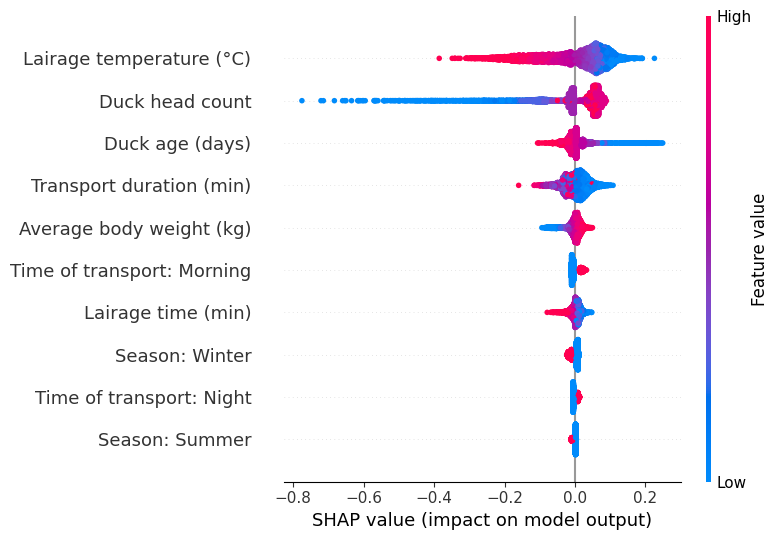

In [86]:
import shap
import matplotlib.pyplot as plt

# ✅ Generate the SHAP Beeswarm Plot with Custom Labels
shap.summary_plot(
    shap_values_high,
    X_train_np,
    feature_names=feature_names_renamed,  # Use the new feature names
    max_display=10,
    show=False  # Do not display immediately
)

# ✅ Save the plot with high resolution
plt.savefig("shap_summary_plot_beeswarm.png", dpi=600, bbox_inches="tight")
plt.show()

## **Dependence Plot**

In [58]:
X_train_np = np.array(X_train_np, dtype=float)  # Ensure features are numeric
shap_values_high = np.array(shap_values_high)   # Ensure SHAP values are numeric

**Lairage temp VS transport duration**

<Figure size 640x480 with 0 Axes>

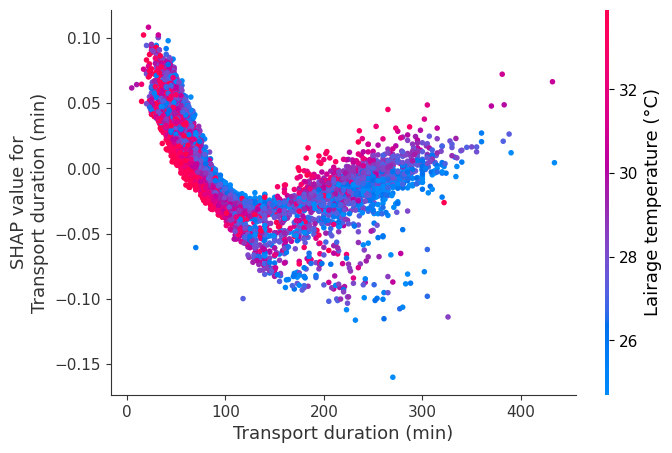

In [87]:
# durationtransport
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=4,  # Feature index for 'durationtransport'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names_renamed,  # List of feature names
        interaction_index=3, # Lairagetemp
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_durationtrans_Lairagetemp.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

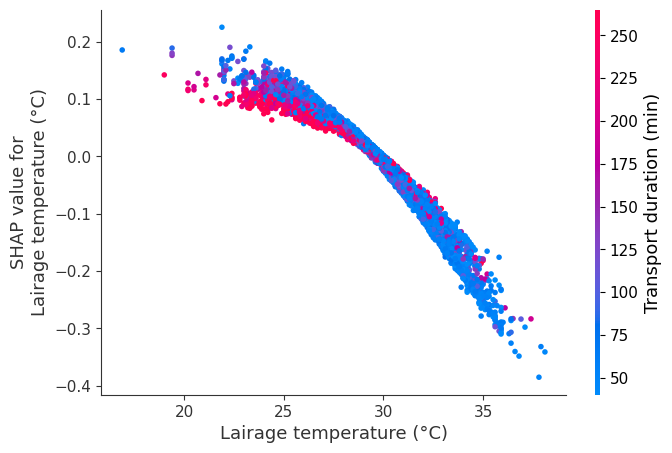

In [88]:
# Lairagetemp
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'Lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names_renamed,  # List of feature names
        interaction_index=4, # durationtransport
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetemp_durationtrans.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

**Lairage temp VS head**

<Figure size 640x480 with 0 Axes>

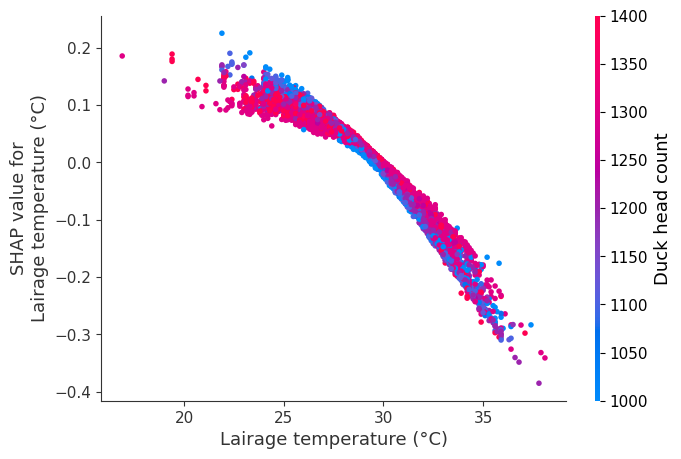

In [89]:
# Lairagetemp
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'Lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names_renamed,  # List of feature names
        interaction_index=0, # head
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetemp_head.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

**Lairagetemp VS bw**

<Figure size 640x480 with 0 Axes>

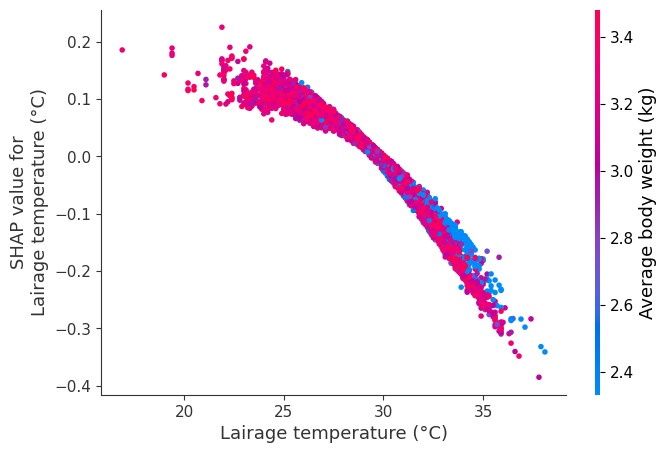

In [90]:
# Lairagetemp
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'Lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names_renamed,  # List of feature names
        interaction_index=2, # bw
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetemp_bw.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

**Lairage temp VS timetransport_Morning**

<Figure size 640x480 with 0 Axes>

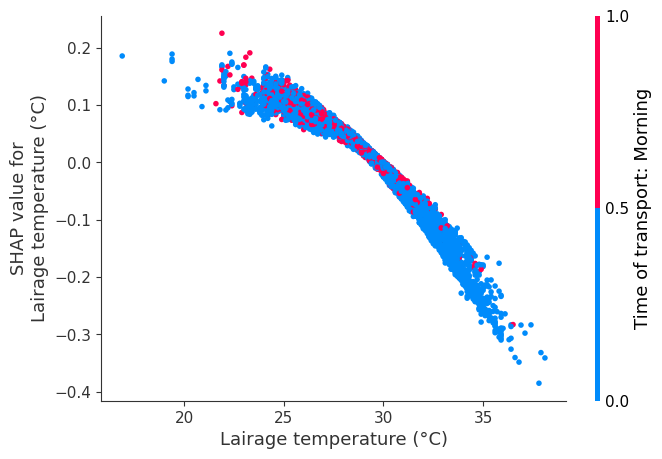

In [91]:
# Lairagetemp
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'Lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names_renamed,  # List of feature names
        interaction_index=8, # timetransport_Morning
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetemp_timeMN.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

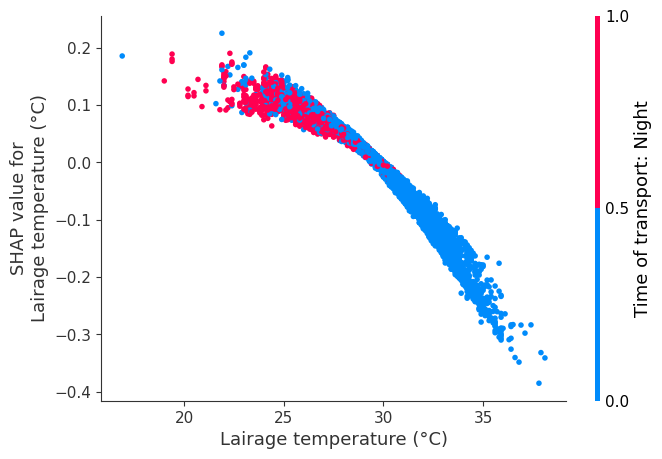

In [92]:
# Lairagetemp
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'Lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names_renamed,  # List of feature names
        interaction_index=9, # timetransport_Night
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetemp_timeNight.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

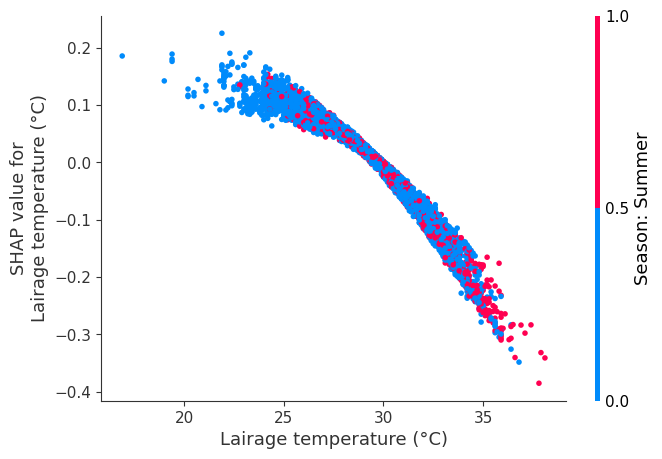

In [93]:
# Lairagetemp
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'Lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names_renamed,  # List of feature names
        interaction_index=6, # season_Summer
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetemp_ssSummer.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

<Figure size 640x480 with 0 Axes>

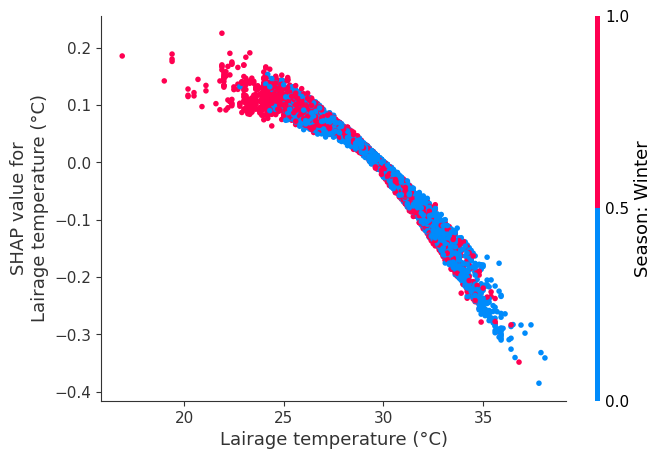

In [94]:
# Lairagetemp
import shap
import matplotlib.pyplot as plt

# Plot dependence for a single feature
plt.figure()
try:
    shap.dependence_plot(
        ind=3,  # Feature index for 'Lairagetemp'
        shap_values=shap_values_high,  # SHAP values for the 'high' class
        features=X_train_np,  # Feature dataset
        feature_names=feature_names_renamed,  # List of feature names
        interaction_index=7, # season_Winter
        show=False
    )
    # Save the plot with high resolution
    plt.savefig("dependence_lairagetemp_ssWinter.png", dpi=600, bbox_inches="tight")
    plt.show()
except Exception as e:
    print(f"Error generating dependence plot: {e}")

## **Waterfall plot**

In [78]:
import shap
import matplotlib.pyplot as plt

# ✅ Ensure the SHAP explainer is defined
explainer = shap.Explainer(fine_tuned_model, X_train_df)

# ✅ Extract the specified data points from X_train_df
selected_rows = [788, 13, 1281, 2952]

# Ensure the selected indices exist in the dataset
X_selected = X_train_df.iloc[selected_rows]

# ✅ Compute SHAP values for selected samples
shap_values_selected = explainer(X_selected)

# ✅ Plot Waterfall Charts for Each Selected Sample (High DOA Class)
for i, index in enumerate(selected_rows):
    plt.figure(figsize=(8, 6))
    shap.plots.waterfall(shap_values_selected[i, 1])  # Selects only class 1 (high DOA)
    plt.title(f"SHAP Waterfall Plot for Row {index}")
    plt.savefig(f"shap_waterfall_row_{index}.png", dpi=600, bbox_inches="tight")
    plt.show()

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 800x600 with 0 Axes>

# **Save files & Make the work reproducible**
remove # for running the code

In [11]:
#!pip freeze > requirements.txt

In [12]:
#from google.colab import files
#files.download('requirements.txt')

In [13]:
#os.listdir()

In [14]:
#!zip -r project_baseline.zip *

In [15]:
#from google.colab import files
#files.download("project_baseline.zip")

# **Reproduce the Environment**

In [16]:
#pip install -r requirements.txt


### ▶ ALL DONE ◀



